<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0-Phase-2/blob/master/02-MobileNet/01_IFODataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IFO Dataset (Identified Flying Objects)

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
from torch.utils.data import Dataset, Subset, DataLoader
import numpy as np
import os
import random
from PIL import Image
import torch
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from pathlib import Path
from zipfile import ZipFile
from pprint import pprint
import json
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
sns.set()

In [ ]:
class IFODataset(Dataset):
    """ 
        Dataset generator for MobileNetV2 implementation on Identified
        flying objects dataset
    """
    
    class_names = ['Flying_Birds', 'Large_QuadCopters', 'Small_QuadCopters', 'Winged_Drones']

    def __init__(self, root, source_zipfile, transform=None):

        self.root = Path(root) / 'IFO'
        self.root.mkdir(parents=True, exist_ok=True)
        self.source_zipfile = Path(source_zipfile)
        self.transform = transform

        if os.path.isdir(self.root / 'IFOCleaned'):
            print(f"dataset folder/files already exist in {self.root / 'IFOCleaned'}")
        else:
            self.extractall()

        self.images_paths = sorted(list(Path(self.root / 'IFOCleaned').glob('*/*.jpg')))
        self.targets = [self.class_names.index(image_path.parent.name) for image_path in self.images_paths]

        print(f'found {len(self.images_paths)} images in total')
        l = list(dataset.targets)
        images_per_class = dict((dataset.class_names[x],l.count(x)) for x in set(l))
        print(json.dumps(images_per_class, indent=4))

        # split indices to train and test, use stratify to distribute equally
        self.train_idxs, self.test_idxs = train_test_split(np.arange(len(self.images_paths)), test_size=0.3, shuffle=True, stratify=self.targets)
    
    def extractall(self):
        print('Extracting the dataset zip file')
        zipf = ZipFile(self.source_zipfile, 'r')
        zipf.extractall(self.root)

    def split_dataset(self):
        return Subset(self, indices=self.train_idxs), Subset(self, self.test_idxs)
    
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, index):

        image_path = self.images_paths[index]
        image = Image.open(image_path)
        image = image.convert('RGB')

        target = self.targets[index]
        
        if self.transform:
            image = self.transform(image)

        return image, target

In [ ]:
dataset = IFODataset(root='data', source_zipfile='/drive/My Drive/IFODataset/IFOCleaned.zip',  transform=T.Compose([T.Resize((224, 224)), T.ToTensor()]))

dataset folder/files already exist in data/IFO/IFOCleaned
found 22193 images in total
{
    "Flying_Birds": 8164,
    "Large_QuadCopters": 4886,
    "Small_QuadCopters": 3612,
    "Winged_Drones": 5531
}


In [ ]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=1)

In [ ]:
# train_subset, test_subset = dataset.split_dataset()

In [ ]:
batch = iter(dataloader)

In [ ]:
next_batch = next(batch)

In [ ]:
def plot_batch(batch):
    fig = plt.figure(figsize=(12, 12))
    images, targets = batch
    
    for i in range(16):
        plt.subplot(4, 4, i+1)
        img, target = images[i], targets[i]
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.title(IFODataset.class_names[target.cpu().numpy()])
        plt.axis('off')

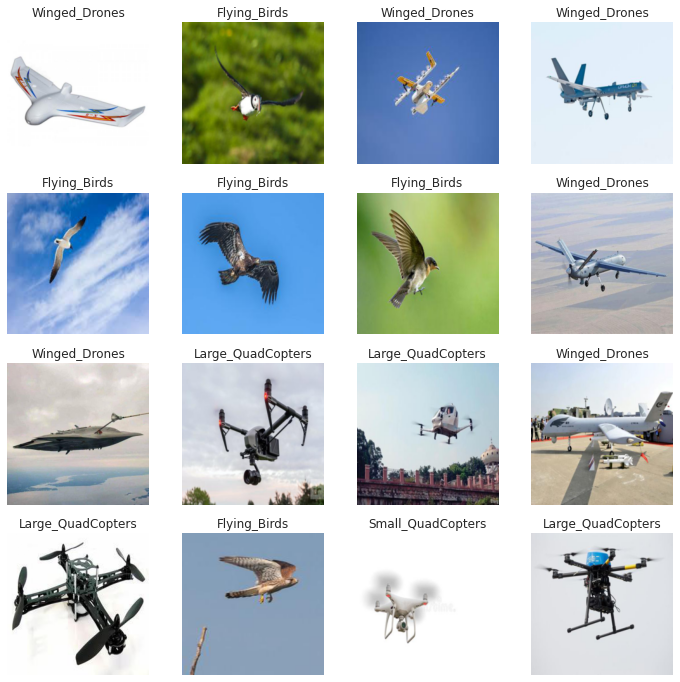

In [ ]:
plot_batch(next_batch)

In [ ]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=1, shuffle=True, num_workers=1)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for images, _ in tqdm(dataloader):
        for i in range(3):
            mean[i] += images[:, i, :, :].mean()
            std[i] += images[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [ ]:
mean, std = get_mean_and_std(dataset=dataset)

==> Computing mean and std..


In [ ]:
f"mean = {[f'{m:.15f}' for m in mean]}", f"std = {[f'{s:.15f}' for s in std]}"

("mean = ['0.533459901809692', '0.584880530834198', '0.615305066108704']",
 "std = ['0.172962218523026', '0.167985364794731', '0.184633478522301']")